# Predykcja przeżycia pasażera na pokładzie RMS Titanic 
## Projekt końcowy z przedmiotu <b>Podstawy uczenia maszynowego</b>
## Karol Nawrot, Michał Miękina


### Opis sytuacji 
RMS Titanic – brytyjski transatlantyk typu Olympic, brytyjskiego towarzystwa okrętowego White Star Line. W nocy z 14 na 15 kwietnia 1912 roku, podczas dziewiczego rejsu na trasie Southampton – Cherbourg – Queenstown – Nowy Jork, zderzył się z górą lodową i zatonął. Zginęło `1502` sprośród `2224` osób na pokładzie, co daje około `32%` przeżywalności.

Niektóre grupy osób (dzieci, kobiety oraz klasa wyższa) miały większy wskaźnik przeżywalności niż pozostali. 
W danych widać też pewną zależność od narodowości (bycie Brytyjczykiem zmniejszało szanse przeżycia mężczyzn o 7% względem średniej, bycie Amerykaninem – zwiększało te szanse w stosunku do średniej o 8,5%). Niestety w naszym zestawie danych brakuje zmiennej określającej narodowość.

> Jednym z powodów takiej wysokiej śmiertelności był brak dostatecznej ilości łodzi ratunkowych, spowodowany przestarzałymi przepisami


Pierwszym etapem będzie wczytanie danych oraz omówienie argumentów.

Dane są w formacie .csv oraz są od razu podzielone na zbiór testowy oraz treningowy

In [39]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [40]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Opis kolumn
* **PassengerId** - unikalny identyfikator pasażera
* **Survived** - jest to etykieta która będziemy próbować przewidzieć, `0` oznacza `śmierć`, `1` - `przeżycie`
* **Pclass** - klasa biletu, możemy po tym mniej więcej określić klasę społeczną pasażerów, `1` oznacza `klasę wyższą`, `2` - `klasę średnią`, `3` - `klasę niższą`
* **Name** - Nazwa pasażera, jedyną użyteczną informacją dla nas może być tutaj tytuł danego pasażera, jeżeli takowy ma
* **Sex** - Płeć pasażera, mamy tutaj dwie kategorie - `male` oraz `female`
* **Age** - Wiek pasażera w latach, są to wartości z zakresu `0-80`, jeżeli wiek był mniejszy niż rok to jest ułamkiem dziesiętnym, jeżeli wiek danego pasażera był przybliżeniem to oznaczony jest końcówką .5
* **SibSp** - Ilość rodzeństwa (w tym mąż/żona) na pokładzie
* **Parch** - Ilość rodziców/dzieci na pokładzie
* **Ticket** - unikalny identyfikator biletu
* **Fare** - Opłata za bilet
* **Cabin** - Numer kabiny pasażera
* **Embarked** - Port w którym pasażer wszedł na pokład `C` = `Cherbourg`, `Q` = `Queenstown`, `S` = `Southampton`

 W przypadku kolumn **Survived**, **Sex** (dokładniej to skala dychotomiczna - tylko 2 wartości), **Embarked** mamy do czynienia z skalą nominalną (jedyną  relacją w tej skali jest równość)
 
 **Pclass** to dane ze skali porządkowej (elementy możememy ułożyć w pewną kolejność, ale nie znamy dokładnych odległości pomiędzy nimi)

 **Age**, **Fare** - Wartości ciągłe (skala ilorazowa - róznice jak i ilorazy mają swoją interpretacje)

  **SibSp**, **Parch** - Wartości dyskretne

### Analiza danych

In [41]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [43]:
train_df.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Rosblom, Mr. Viktor Richard",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Z opisu danych możemy wynieść kilka spostrzeżeń:
 * Wszystkie nazwy pasażerów są unikalne
 * 65% Pasażerów to mężczyźni
 * W naszym testowym datasecie wskaźnik przeżycia wynosił 38%
 * Wiele wartości dla kabin się powtarza, to znaczy, że niektórzy pasażerowie mieli wspólne kabiny
 * 22% biletów ma identyczne identyfikatory - możliwe, że istniały bilety wieloosobowe

 
Mamy dużo brakujących informacji o wieku (`około 20%`) oraz o kabinie pasażera (`~80%`).
 Kilka wierszów nie posiada również portu rozpoczęcia rejsu. 


Sprawdzimy teraz kilka zależności widocznych w danych, konkretniej przeżywalność w zależności od płci, klasy biletu i wieku

         Survived
Pclass           
Class 1  0.629630
Class 2  0.472826
Class 3  0.242363


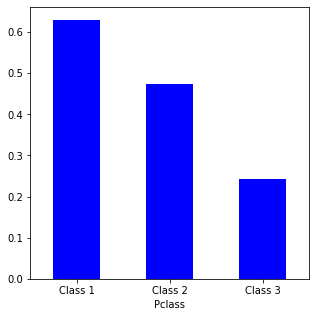

In [44]:
pclass_to_survival=train_df[["Pclass", "Survived"]].groupby(['Pclass'], as_index=True).mean()
pclass_to_survival=pclass_to_survival.rename(index={1:'Class 1',2:"Class 2",3:"Class 3"})
print(pclass_to_survival)

plot = pclass_to_survival.plot.bar(figsize=(5,5),rot="0",color=["b",'r','g'],legend=False)

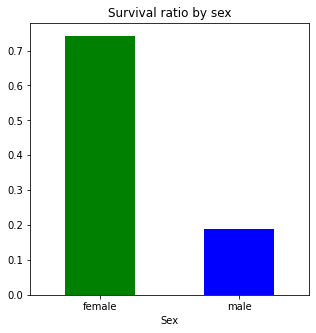

In [45]:
sex_to_survival=train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()
plot=sex_to_survival.plot.bar(figsize=(5, 5),x='Sex',y='Survived',rot=0,color=['green','blue'],legend=False,title="Survival ratio by sex")


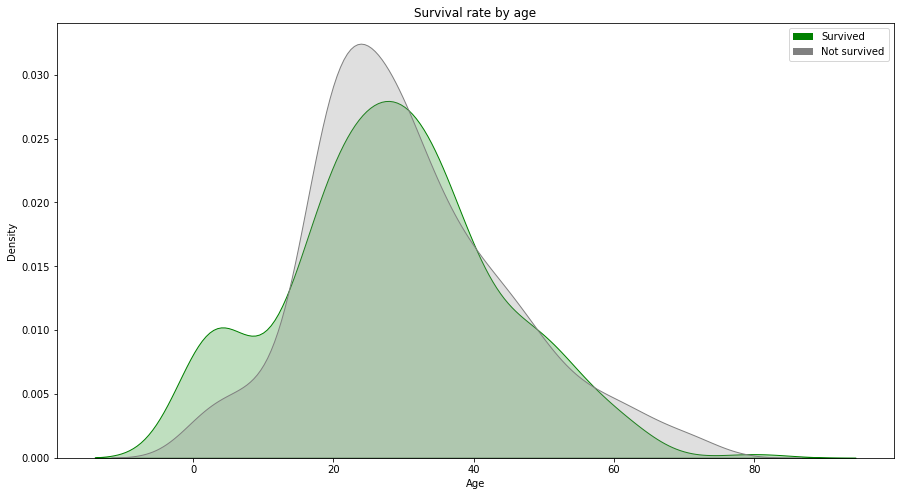

In [46]:
import seaborn as sns
import matplotlib.patches as  mpatches
from matplotlib import pyplot as plt
%matplotlib inline

survived_age=train_df.loc[(train_df['Survived'] == 1),'Age']
not_survived_age=train_df.loc[(train_df['Survived'] == 0),'Age']

fig = plt.figure(figsize=(15,8),)
#jądrowy estymator gęstości
plot1=sns.kdeplot(data=survived_age, color="green",shade=True)
plot2=sns.kdeplot(data=not_survived_age, color="gray",shade=True)

handles = [mpatches.Patch(facecolor='green', label="Survived"),
           mpatches.Patch(facecolor='gray', label="Not survived")]
plt.legend(handles=handles)
plt.title("Kernel density estimate of survival rate by age")
plt.show()

Widać tutaj że pasażerowie z wyższą klasą społeczną mieli większy wskaźnik przeżywalności. W przypadku klasy wyższej (`1`) szanse na przeżycie wynosiły średnio `63%` 

Co do płci pasażerów, różnice między mężczyznami a kobietami są dosyć duże - ponad 70% dla kobiet, podczas gdy dla mężczyzn jest to niecałe `20%`

Co do wieku pasażerów - dzieci i niemowlęta znacznie częściej przeżywały, poza tym nie widzimy tutaj nic specjalnego

Dzięki potwierdzeniu tych zależności mamy pewność, że dane kolumny płci oraz klasy biletu będą miały duże znaczenie przy przewidywaniu przeżycia dla danego pasażera, natomiast wiek może znacząco wskazywać na przeżycie tylko gdy pasażer był dzieckiem



### Czyszczenie danych



In [47]:
print("Train dataset null values \n")
print(train_df.isnull().sum())
print("\n Test dataset null values \n")
print(test_df.isnull().sum())

Train dataset 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

 Test dataset 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Jako że wiele wierszy nie posiada wartości wieku - zdecydowaliśmy, że zamiast wyrzucać dosyć dużą część danych (20%) - uzupełnimy brakujący wiek pasażerów poprzez wstawienie mediany wieku dla danej klasy społecznej pasażera.

Uzupełnimy również kilka brakujących wartości dla Embarked - poprzez wstawienie najczęściej występującej wartości, oraz dla Fare - poprzez wstawienie mediany


In [48]:
train_df.Age.fillna(train_df.groupby(['Sex','Pclass']).transform('median').Age, inplace=True)
test_df.Age.fillna(train_df.groupby(['Sex','Pclass']).transform('median').Age, inplace=True)
train_df.Fare.fillna(train_df.Fare.median(), inplace=True)
test_df.Fare.fillna(test_df.Fare.median(), inplace=True)
train_df.Embarked.fillna(train_df.Embarked.mode()[0], inplace=True)
test_df.Embarked.fillna(test_df.Embarked.mode()[0], inplace=True)

train_df.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,204,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Rosblom, Mr. Viktor Richard",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,646
mean,446.000000,0.383838,2.308642,NaN,NaN,29.112424,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,13.304424,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,21.500000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,26.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,36.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [49]:
print("Train dataset null values\n")
print(train_df.isnull().sum())
print("\n Test dataset null values\n")
print(test_df.isnull().sum())

Train dataset null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

 Test dataset null values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Następnie możemy pomyśleć nad pozbyciem się zbędnych danych z naszego zbioru danych.

Z pewnościa możemy pozbyć się danych o identyfikatorze biletu i pasażera (**Ticket**, **PassengerId**), ponieważ z dużym prawdopodobieństwem nie istnieje żadna zależność pomiędzy przeżyciem danej osoby, a tymi wartościami.

Usuniemy również kolumnę **Cabin**, gdyż większość tych wartości brakuje i nie ma sensu ich uzupełniać.

Z danych o nazwie pasażera teoretycznie możnaby wyciągnąć tytuł pasażera i sprawdzić czy istnieje jakaś znacząca korelacja między tytułem, a przeżyciem. Zdecydowaliśmy jednak, że usuniemy tą kolumną z danych.

In [50]:
train_df = train_df.drop(['Ticket', 'Cabin','PassengerId','Name'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin','PassengerId','Name'], axis=1)

train_df.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,646
mean,0.383838,2.308642,NaN,29.112424,0.523008,0.381594,32.204208,NaN
std,0.486592,0.836071,NaN,13.304424,1.102743,0.806057,49.693429,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,21.500000,0.000000,0.000000,7.910400,NaN
50%,0.000000,3.000000,NaN,26.000000,0.000000,0.000000,14.454200,NaN
75%,1.000000,3.000000,NaN,36.000000,1.000000,0.000000,31.000000,NaN


Możemy również połączyć liczbę rodziców/dzieci z liczbą małżonków/rodzeństwa jako całkowitą ilość członków rodziny na pokładzie (licząc również danego pasażera).
Pozwoli nam to zredukować trochę ilość zmiennych.

In [51]:
train_df['FamilySize'] = train_df ['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df ['SibSp'] + test_df['Parch'] + 1

train_df = train_df.drop(['SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)

train_df.describe(include = 'all')


,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
count,891.000000,891.000000,891,891.000000,891.000000,891,891.000000
unique,NaN,NaN,2,NaN,NaN,3,NaN
top,NaN,NaN,male,NaN,NaN,S,NaN
freq,NaN,NaN,577,NaN,NaN,646,NaN
mean,0.383838,2.308642,NaN,29.112424,32.204208,NaN,1.904602
std,0.486592,0.836071,NaN,13.304424,49.693429,NaN,1.613459
min,0.000000,1.000000,NaN,0.420000,0.000000,NaN,1.000000
25%,0.000000,2.000000,NaN,21.500000,7.910400,NaN,1.000000
50%,0.000000,3.000000,NaN,26.000000,14.454200,NaN,1.000000
75%,1.000000,3.000000,NaN,36.000000,31.000000,NaN,2.000000


In [52]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


Przekonwertujemy kategorie (**Sex**, **Embarked**) z danych tekstowych na numeryczne, ponieważ większość algorytmów nie przyjmuje tekstowych danych.




In [53]:
train_df['Embarked'] = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_df['Embarked'] = test_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train_df['Sex'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test_df['Sex'] = test_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.describe(include = 'all')

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.112424,32.204208,0.361392,1.904602
std,0.486592,0.836071,0.477990,13.304424,49.693429,0.635673,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,21.500000,7.910400,0.000000,1.000000
50%,0.000000,3.000000,0.000000,26.000000,14.454200,0.000000,1.000000
75%,1.000000,3.000000,1.000000,36.000000,31.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,2.000000,11.000000


Po przeprowadzeniu czyszczenia danych, nasza tabela jest dwukrotnie szczuplejsza i nie zawiera już stringów ani żadnych innych objektów bardziej specyficznych niż int czy float.  Zmienne numeryczne ułatwią nam realizację uczenia maszynowego za pomocą wybranych technik.

In [54]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,22.0,7.2500,0,2
1,1,1,1,38.0,71.2833,1,2
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,0,2
4,0,3,0,35.0,8.0500,0,1
5,0,3,0,25.0,8.4583,2,1
6,0,1,0,54.0,51.8625,0,1
7,0,3,0,2.0,21.0750,0,5
8,1,3,1,27.0,11.1333,0,3
9,1,2,1,14.0,30.0708,1,2


Sprawdźmy jak obecnie prezentuje się wykres przedstawiający zależność przeżywalności i wieku.

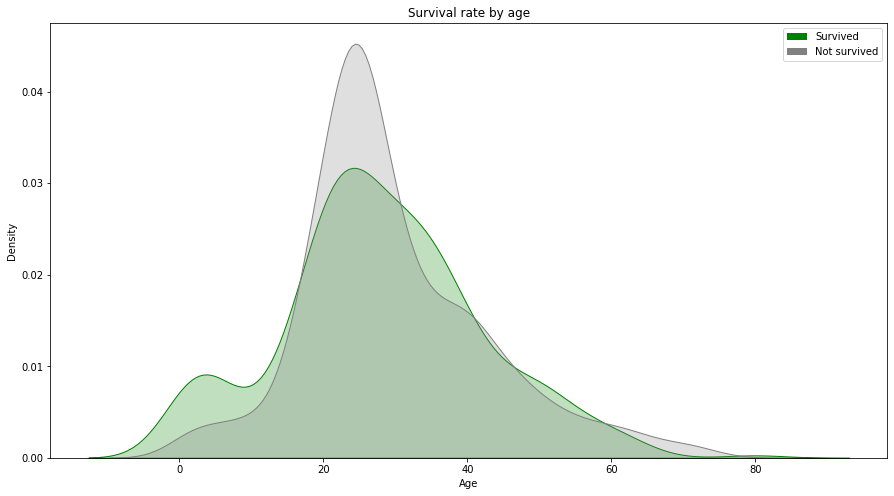

In [57]:
survived_age=train_df.loc[(train_df['Survived'] == 1),'Age']
not_survived_age=train_df.loc[(train_df['Survived'] == 0),'Age']

fig2 = plt.figure(figsize=(15,8),)
plot1=sns.kdeplot(data=survived_age, color="green",shade=True)
plot2=sns.kdeplot(data=not_survived_age, color="gray",shade=True)

handles = [mpatches.Patch(facecolor='green', label="Survived"),
           mpatches.Patch(facecolor='gray', label="Not survived")]
plt.legend(handles=handles)
plt.title("Survival rate by age")
plt.show()

Krzywa osób które przetrwały delikatnie się wypłaszczyła, lecz wciąż wyraźnie widać utrzymujący się trend który wcześniej opisaliśmy - osoby najmłodsze (dzieci) mają znacznie wyższą szansę przeżycia, podobnie ma się sytuacja w przypadku osób w wieku 30-40 lat (najprawdopodobniej ta część statystyki jest spowodowana przez matki z dziećmi, które są traktowane priorytetowo w przypadku ewakuacji). Natomiast młodzi pełnoletni (18-30) oraz pasażerowie w podeszłym wieku (60+) znacznie częściej byli śmiertelnymi ofiarami ów katastrof.